# Voxel-level Simulations
This notebook simulates a single fibre and crossing fibre voxel-level configuration to validate LoRE-SD. Every configuration will be tested at multiple signal-to-noise ratios (SNR) to evaluate the robustness of the method.

Some of this code makes use of the MRtrix3 software. Please make sure to have it installed and available in your PATH.

In [1]:
import os

SAVE_DIR = '/LOCALDATA/sleyse4' # Replace with the directory where you want to save the results

# We use MRtrix3 for some of the preprocessing steps (e.g. dwi2response and dwi2fod)
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
import subprocess

import numpy as np
import matplotlib.pyplot as plt

from lore_sd.utils import gradient_utils, math_utils, plot_utils
from lore_sd.utils import SphericalHarmonics as sh

from lore_sd.simulation import simulation
from lore_sd.optimisation import optimise
from lore_sd.mrtrix_io.io import load_mrtrix, save_mrtrix
from lore_sd.mrtrix_io.io.image import Image

In [4]:
# # Add the MRtrix3 binary directory to the PATH
# mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
# os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

## Constants

In [24]:
lmax = 8

grad = gradient_utils.create_gradient_table([0, 1000, 2000], [2, 128, 128])
bvals = np.unique(np.round(grad[...,-1], -2))

# Create and save the transformation matrix to avoid generating it for every experiment
Q = optimise.get_transformation_matrix(600, lmax)
np.save(os.path.join(SAVE_DIR, 'Q.npy'), Q)

dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 1.4142135623730949
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.712611581414
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.712611572804
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 348368.7158859233


In [25]:

gradient_utils.pretty_print_gradient_table(grad)

# Multiprocessing reduces the time to run the simulations
cores = 10

b-value   |   count   
----------------------
    0     |   2
 1000     |   128
 2000     |   128


In [26]:
# LoRE-SD Parameters
reg = 1e-3

axial_diffusivities = np.linspace(0, 4e-3, 10)
radial_diffusivities = np.linspace(0, 4e-3, 10)

gaussians = optimise.get_gaussians(axial_diffusivities, radial_diffusivities, bvals, lmax)

## Simulated Configurations
The following fibre configurations will be simulated:
1. Single Fibre
2. Crossing Fibres at 60 degrees

The response function will be a combination of a stick, zeppelin and water compartments with 45%, 45% and 10% volume fraction respectively.
* Stick compartment: $ \lambda_\parallel = 2.2 \mu m^2/ms$, $\lambda_\perp = 0 \mu m^2 / ms$
* Zeppelin compartment: $\lambda_\parallel = 2 \mu m^2/ms$, $\lambda_\perp = 0.7e \mu m^2/ms$
* Water compartment: $\lambda_\parallel = \lambda_\perp = 3 \mu m^2 / ms$.

In [27]:
# Single Fibre ODF
single_fibre = simulation.getOrientedApodizedDirac(0, 0, lmax)
# Crossing Fibre ODF at 60 degrees
crossing_60 = .5*simulation.getOrientedApodizedDirac(0, 0, lmax) + .5*simulation.getOrientedApodizedDirac(60, 0, lmax)

In [28]:
stick = sh.zhgaussian(bvals, 2.2e-3, 0)
zeppelin = sh.zhgaussian(bvals, 2e-3, .7e-3)
water = sh.zhgaussian(bvals, 3e-3, 3e-3)

sane_rf = .45*stick + .45*zeppelin + .1*water

Text(0.5, 1.0, 'Response Function')

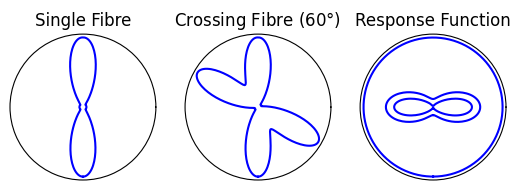

In [29]:
fig = plt.figure()

gridspec = fig.add_gridspec(nrows=1, ncols=3)
ax_single_fibre = fig.add_subplot(gridspec[0,0], projection='polar')
ax_crossing_fibre = fig.add_subplot(gridspec[0,1], projection='polar')
ax_response = fig.add_subplot(gridspec[0,2], projection='polar')

sh.plot_odf_on_axis(single_fibre, ax=ax_single_fibre)
sh.plot_odf_on_axis(crossing_60, ax=ax_crossing_fibre)
sh.plot_wmr_on_axis(sane_rf, bvals, ax=ax_response)

ax_single_fibre.set_title('Single Fibre')
ax_crossing_fibre.set_title(r'Crossing Fibre ($60\degree$)')
ax_response.set_title('Response Function')

## Simulation Functions
Functions to simulate a single voxel with a given fibre configuration and SNR. The function `add_noise` adds Rician noise to the signal. The function `run_msst_csd` estimates the ODF using MSMT-CSD. The function `run_simulation` simulates the voxel and estimates the ODF using LoRE-SD and MSMT-CSD.

In [30]:
def add_noise(noise_free, grad, snr):
    """
    Add Gaussian noise or Rician noise to a signal.

    Returns:
        numpy.ndarray: A signal with added Gaussian/Rician noise.
    """

    mean_b0 = np.mean(noise_free[..., np.where(grad[...,-1] == 0)[0]])

    std_noise = mean_b0 / snr
    noise1 = np.random.normal(0, std_noise, size=noise_free.shape)
    noise2 = np.random.normal(0, std_noise, size=noise_free.shape)
    noisy_dwi = np.sqrt((noise_free + noise1)**2 + noise2**2)

    return noisy_dwi

In [31]:
def run_msmt_csd(dwi, mask, rf, odf_out, pred_out):
    # Run the MSMT-CSD algorithm
    csd_cmd = f'dwi2fod msmt_csd {dwi} {rf} {odf_out} -predicted_signal {pred_out} -mask {mask} -force'
    subprocess.run(csd_cmd, shell=True)

def run_lore_sd(dwi, mask, odf_out, pred_out, rf_out):
    # Run the LoRE-SD algorithm (including the previously generated transformation matrix)
    lore_cmd = (
        f'dwi2decomposition {dwi} '
        f'{os.path.dirname(odf_out)} --cores 10 --mask {mask} --eval_matrix {os.path.join(SAVE_DIR, "Q.npy")}'
    )
    subprocess.run(lore_cmd, shell=True)
    subprocess.run(f'mv {os.path.join(os.path.dirname(odf_out), "odf.mif")} {odf_out}', shell=True)
    subprocess.run(f'mv {os.path.join(os.path.dirname(odf_out), "reconstructed.mif")} {pred_out}', shell=True)
    subprocess.run(f'mv {os.path.join(os.path.dirname(odf_out), "response.mif")} {rf_out}', shell=True)


### Simulation Variables

In [32]:
num_its_simulation = 500

snrs = [10, 20, 50, np.inf]

noise_free_single_fibre_voxel = sh.calcdwi(sh.sphconv(sane_rf, single_fibre), grad)
noise_free_single_fibre_dwi = np.repeat(noise_free_single_fibre_voxel[np.newaxis,...],
                                        num_its_simulation, axis=0).reshape((num_its_simulation, 1, 1, -1))


noise_free_crossing_60_voxel = sh.calcdwi(sh.sphconv(sane_rf, crossing_60), grad)
noise_free_crossing_60_dwi = np.repeat(noise_free_crossing_60_voxel[np.newaxis,...],
                                       num_its_simulation, axis=0).reshape((num_its_simulation, 1, 1, -1))

In [33]:
# Since this is a simulation, all voxels belong to the mask
mask = np.ones(noise_free_single_fibre_dwi.shape[:-1], dtype=bool)

# Simulations

In [34]:
np.savetxt(os.path.join(SAVE_DIR, 'response.txt'), sane_rf)

In [35]:
for snr in snrs:
    for fibre_config, gt_odf, noise_free_dwi in zip(['single', 'crossing'], [single_fibre, crossing_60],
                                            [noise_free_single_fibre_dwi, noise_free_crossing_60_dwi]):
        noisy_dwi = add_noise(noise_free_dwi, grad, snr)

        save_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif'), Image(noisy_dwi, grad=grad))
        mask = np.ones_like(noisy_dwi[...,0], dtype=float)
        save_mrtrix(os.path.join(SAVE_DIR, f'mask.mif'), Image(mask))

        run_lore_sd(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif'), os.path.join(SAVE_DIR, f'mask.mif'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_odf.mif'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_pred.mif'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_rf.mif'))
        run_msmt_csd(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}.mif'), os.path.join(SAVE_DIR, f'mask.mif'), os.path.join(SAVE_DIR, 'response.txt'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_msmt_odf.mif'), os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_msmt_pred.mif'))


Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 302.44it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 299.71it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 290.14it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 282.11it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 291.90it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 306.57it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 309.23it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

Regularisation: 0.001
Grid size: 10 x 10


100%|██████████| 500/500 [00:01<00:00, 298.52it/s]
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda/anaconda3/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 160, in decompose_voxel
    init, bounds = get_init_and_bounds_from_csd(lmax, Da, Dr, gaussians, S, [constraints.non_negative_odf(Q)])
  File "/home/sleyse4/repos/LoRE_SD/src/lore_sd/optimisation/optimise.py", line 207, in get_init_and_bounds_from_csd
    init_rf = np.einsum('a, acd -> cd', init_fs, scaled_gaussians)
  File "<__array_function__ internals>", line 5, in einsum
  File "/opt/anaconda/anaconda3/lib/python3.9/site-packages/numpy/core/einsumfunc.py", line 1359, in einsum
    return c_einsum(*op

In [36]:
from matplotlib.pyplot import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='orange')
    setp(bp['caps'][2], color='orange')
    setp(bp['caps'][3], color='orange')
    setp(bp['whiskers'][2], color='orange')
    setp(bp['whiskers'][3], color='orange')
    setp(bp['medians'][1], color='orange')

FileNotFoundError: [Errno 2] No such file or directory: '/LOCALDATA/sleyse4/single_10_lore_odf.mif'

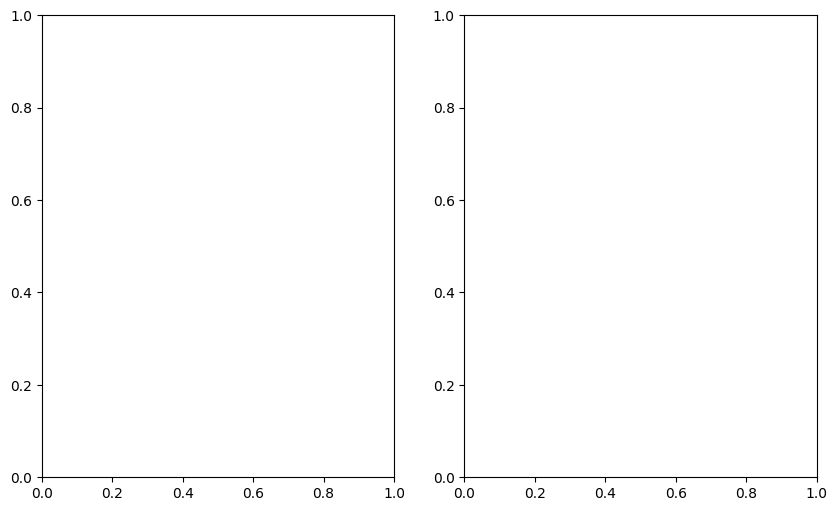

In [37]:
# Boxplots of the angular correlation coefficients
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
snrs = [10, 20, 50, np.inf]
snr_strings = ['10', '20', '50', r'$\infty$']

for fibre_config, ax in zip(['single', 'crossing'], axs.T):
    for i, snr in enumerate(snrs):
        odf_lore = load_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_lore_odf.mif')).data[mask>0]
        odf_msmt = load_mrtrix(os.path.join(SAVE_DIR, f'{fibre_config}_{snr}_msmt_odf.mif')).data[mask>0]

        gt_odf = single_fibre if fibre_config == 'single' else crossing_60

        acc_lore = sh.angularCorrelation(odf_lore, gt_odf)
        acc_msmt = sh.angularCorrelation(odf_msmt, gt_odf)

        bp = ax.boxplot(
            [acc_lore, acc_msmt],
            positions=[1 + 3 * i, 2 + 3 * i],
            widths=0.6,
            showfliers=False
        )
        setBoxColors(bp)
    ax.set_xticks([1.5 + 3 * i for i in range(len(snrs))])
    ax.set_xticklabels(snr_strings, fontsize=12)
    ax.set_xlabel('SNR')
    ax.set_yticks([.7,.8,.9,1])
    ax.set_ylim([.7, 1])
    if ax != axs.T[0]:
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels([.7,.8,.9,1], fontsize=12)
    title = 'Single Fibre' if fibre_config == 'single' else 'Crossing Fibre'
    ax.set_title(title, fontsize=15)

axs[0].set_ylabel('ODF Angular Correlation Coefficient', fontsize=12)

# draw temporary red and blue lines and use them to create a legend
hB, = axs[-1].plot(5, 1,'-', color='blue', label='hB')
hR, = axs[-1].plot(5, 1,'-', color='orange', label='hR')
patches, _ = axs[-1].get_legend_handles_labels()
fig.legend(patches, ['LoRE-SD', 'MSMT-CSD'], fontsize=12, loc='center right', bbox_to_anchor=(.9, .75), frameon=True)
hB.set_visible(False)
hR.set_visible(False)

plt.show()


# Plot the variance within the response function estimations
For every configuration, the variance within the response function estimations is plotted. The variance is calculated for each shell of the response function. The variance is visualized by filling the area between the minimum and maximum values of the response function estimations.

In [ ]:
def fill_kernels(kernels, ax, color):
    # Calculate the maximum degree of spherical harmonics
    lmax = (kernels[0].shape[-1]-1)*2

    # Get the number of shells in the kernel
    num_shells = len(kernels[0])

    # Generate a modified spherical harmonics basis
    Q_k = sh.modshbasis(lmax, np.linspace(0, 2*np.pi, 400), np.zeros(400))

    # Initialize indices for spherical harmonics
    idx = []
    end = 0
    for l in range(0, lmax + 1, 2):
        idx.append(end + (2 * l + 1) // 2)
        end += 2 * l + 1

    # Select the required columns from the basis
    Q_k = Q_k[:,idx]

    # Convert kernels to polar coordinates
    kernels_polar = [kernel @ Q_k.T for kernel in kernels]
    kernels_polar = np.asarray(kernels_polar)

    # Define angles for plotting
    angles = np.linspace(0, 2*np.pi, 400)
    # Plot each shell
    for i in range(num_shells):
        minima = np.squeeze(np.amin(kernels_polar[:,i,:], axis=0))
        maxima = np.squeeze(np.amax(kernels_polar[:,i,:], axis=0))

        # Fill between minima and maxima for each shell
        ax.fill_between(angles - np.pi / 2, minima, maxima, alpha=.2, color=color, edgecolor=(0,0,0,0), linewidth=0)

        # Set xticks if axis is provided
        xlocs = np.arange(0, 2 * np.pi, np.pi / 4)
        ax.set_xticks(xlocs, [''] * len(xlocs))


In [ ]:
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 6))
gs = gridspec.GridSpec(2,1, figure=fig)

# Subplot for Crossing Fibre SNR 20
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
rf_20 = load_mrtrix(os.path.join(SAVE_DIR, 'crossing_20_lore_rf.mif')).data[mask>0]
fill_kernels(rf_20, ax1, 'blue')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel(f'SNR {20}', fontsize=12)
sh.plot_wmr_on_axis(sane_rf, bvals, ax1, c='green')
ax1.set_title('Response function variance', fontsize=15)
ax1.spines['polar'].set_visible(False)

# Subplot for Crossing Fibre SNR 50
ax2 = fig.add_subplot(gs[1,0], projection='polar')
rf_50 = load_mrtrix(os.path.join(SAVE_DIR, 'crossing_50_lore_rf.mif')).data[mask>0]
fill_kernels(rf_50, ax2, 'blue')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel(f'SNR {50}', fontsize=12)
sh.plot_wmr_on_axis(sane_rf, bvals, ax2, c='green')
ax2.spines['polar'].set_visible(False)

plt.show()